In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install geopandas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
pd.set_option("display.precision", 3)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/dataset/madison/'

## Load dataset

In [ ]:
objects = pd.read_csv(path + '/input/objects_embeddings.csv', usecols=['objectid', 'geometry', 'source', 'geom_type', 'n_tokens'])
objects.head()

,objectid,geometry,source,geom_type,n_tokens
0,"road_(6231530142, 3861040918)","LINESTRING (-89.4719 43.05, -89.472 43.05)",link,LineString,21
1,"road_(53591318, 1179412798)","LINESTRING (-89.477 43.0693, -89.477 43.0681)",link,LineString,22
2,"road_(1178722373, 1178722211)","LINESTRING (-89.4626 43.0553, -89.4627 43.0554)",link,LineString,24
3,"road_(53430628, 53468282)","LINESTRING (-89.3045 43.0246, -89.3053 43.0252)",link,LineString,24
4,"road_(3444117858, 6680557104)","LINESTRING (-89.5081 43.0066, -89.5072 43.006)",link,LineString,23


In [ ]:

relations = pd.read_csv(path+'input/relations.csv', usecols=['subjectid', 'objectid', 'predicate', 'relate', 'idx'])
# relations.to_csv('/content/drive/MyDrive/dataset/madison/output/relations_update.csv', index=False)
# relations = pd.read_csv('/content/drive/MyDrive/dataset/madison/output/relations_update.csv')
relations.head()

,objectid,subjectid,predicate,relate,idx
0,"road_(53496379, 5657142535)","road_(5656899646, 53496379)",contains,101F00FF2,0
1,"road_(2634716954, 8997363243)","road_(8997363242, 2634716954)",contains,101F00FF2,1
2,poi_way/1134399612,poi_way/1134399613,contains,1F1FFFFF2,2
3,"road_(1998162788, 1998162839)",poi_way/257174438,contains,101FFFFF2,3
4,"road_(3420767254, 3590603510)",poi_way/287637061,contains,101FFFFF2,4


In [ ]:
relations = pd.merge(relations, objects[['objectid', 'geometry', 'source', 'geom_type','n_tokens']].rename(columns={'objectid': 'subjectid',
                                                        'geometry': 'geometry_subject',
                                                        'source': 'source_subject',
                                                        'geom_type': 'geom_type_subject',
                                                          'n_tokens': 'n_tokens_subject'
                                                        }), on='subjectid', how='inner')
relations = pd.merge(relations, objects[['objectid', 'geometry', 'source', 'geom_type', 'n_tokens']], on='objectid', how='inner')
relations.head()

,objectid,subjectid,predicate,relate,idx,geometry_subject,source_subject,geom_type_subject,n_tokens_subject,geometry,source,geom_type,n_tokens
0,"road_(53496379, 5657142535)","road_(5656899646, 53496379)",contains,101F00FF2,0,"LINESTRING (-89.3397 43.0922, -89.3386 43.0922)",link,LineString,24,"LINESTRING (-89.3386 43.0922, -89.3387 43.0922)",link,LineString,24
1,"road_(2634716954, 8997363243)","road_(8997363242, 2634716954)",contains,101F00FF2,1,"LINESTRING (-89.3554 43.1351, -89.3554 43.1357)",link,LineString,24,"LINESTRING (-89.3554 43.1357, -89.3554 43.1355)",link,LineString,24
2,poi_way/1134399612,poi_way/1134399613,contains,1F1FFFFF2,2,"LINESTRING (-89.4524 43.0716, -89.4521 43.0716...",poi,LineString,57,"LINESTRING (-89.4524 43.0715, -89.4521 43.0715...",poi,LineString,46
3,"road_(1998162788, 1998162839)",poi_way/257174438,contains,101FFFFF2,3,"LINESTRING (-89.3392 43.0637, -89.3399 43.0641...",poi,LineString,134,"LINESTRING (-89.338 43.0659, -89.3378 43.0659)",link,LineString,23
4,"road_(3420767254, 3590603510)",poi_way/287637061,contains,101FFFFF2,4,"LINESTRING (-89.5168 43.0606, -89.5168 43.0616...",poi,LineString,57,"LINESTRING (-89.5175 43.0611, -89.5175 43.0607)",link,LineString,24


In [ ]:
relations[(relations['geom_type_subject']=='Point')&(relations['geom_type']=='LineString')].sort_values(by=['n_tokens_subject', 'n_tokens']).iloc[0]

,3345
objectid,"road_(2633805462, 3423901632)"
subjectid,node_3752320724
predicate,disjoint
relate,FF0FFF102
idx,195
geometry_subject,POINT (-89.456 43.061)
source_subject,intersection
geom_type_subject,Point
n_tokens_subject,10
geometry,"LINESTRING (-89.459 43.0661, -89.459 43.066)"


In [ ]:
relate_df = relations[['geom_type_subject', 'predicate', 'geom_type']].drop_duplicates().reset_index(drop=True)
relate_df['rid'] = relate_df.index
relate_df['output'] = '(' + relate_df['geom_type_subject'] + ',' + relate_df['predicate'] + ',' + relate_df['geom_type'] + ')'
relations = pd.merge(relations, relate_df, on=['geom_type_subject', 'predicate', 'geom_type'], how='left')
# relations = pd.merge(relations, relate_df, on=['geom_type_subject', 'predicate', 'geom_type'], how='left')

In [ ]:
relations_example = relations[relations['idx']>=200].reset_index(drop=True)

relations_test = relations[relations['idx']<40].reset_index(drop=True)

relations_train = relations[(relations['idx']>=40)&(relations['idx']<200)].reset_index(drop=True)

In [ ]:
comb_list = []
for geom_type_subject in ['Point', 'LineString', 'Polygon']:
    for predicate in relate_df['predicate'].unique().tolist():
      for geom_type in ['Point', 'LineString', 'Polygon']:
        comb_list.append(str((geom_type_subject, predicate, geom_type)).replace('\'', '').replace(' ', ''))
len(comb_list)

63

In [ ]:
comb_list

['(Point,contains,Point)',
 '(Point,contains,LineString)',
 '(Point,contains,Polygon)',
 '(Point,crosses,Point)',
 '(Point,crosses,LineString)',
 '(Point,crosses,Polygon)',
 '(Point,disjoint,Point)',
 '(Point,disjoint,LineString)',
 '(Point,disjoint,Polygon)',
 '(Point,equals,Point)',
 '(Point,equals,LineString)',
 '(Point,equals,Polygon)',
 '(Point,overlaps,Point)',
 '(Point,overlaps,LineString)',
 '(Point,overlaps,Polygon)',
 '(Point,touches,Point)',
 '(Point,touches,LineString)',
 '(Point,touches,Polygon)',
 '(Point,within,Point)',
 '(Point,within,LineString)',
 '(Point,within,Polygon)',
 '(LineString,contains,Point)',
 '(LineString,contains,LineString)',
 '(LineString,contains,Polygon)',
 '(LineString,crosses,Point)',
 '(LineString,crosses,LineString)',
 '(LineString,crosses,Polygon)',
 '(LineString,disjoint,Point)',
 '(LineString,disjoint,LineString)',
 '(LineString,disjoint,Polygon)',
 '(LineString,equals,Point)',
 '(LineString,equals,LineString)',
 '(LineString,equals,Polygon)',

## Load result

In [ ]:


def load_result(model, prompt_mode):
  res_llm = pd.read_csv(path+'result/temp/task1_%s_%s.csv'%(model, prompt_mode))

  res_llm_format = res_llm[res_llm['text'].str.contains('answer')]

  res_llm_format1 = res_llm[res_llm['text'].str.contains('<answer>')&(res_llm['text'].str.contains('</answer>'))]

  res_llm_format2 = res_llm[(~(res_llm['text'].str.contains('<answer>')))&((res_llm['text'].str.contains('</answer>')))]


  # res_llm_format3 = res_llm[(res_llm['text'].str.contains('**Answer:**')) & (~(res_llm['text'].str.contains('<answer>')))&(~(res_llm['text'].str.contains('</answer>')))]

  res_llm_other = res_llm[~(res_llm['text'].str.contains('</answer>'))]

  print(res_llm_other.shape[0], res_llm_format.shape[0], res_llm_format1.shape[0], res_llm_format2.shape[0])

  res_llm_format1['output'] = res_llm_format1['text'].str.split('<answer>', expand=True)[1].str.split('</answer>', expand=True)[0]
  res_llm_format2['output'] = res_llm_format2['text'].str.split('</answer>', expand=True)[1].str.split('</answer>', expand=True)[0]

  res_all_llm = pd.concat([res_llm_format1, res_llm_format2, res_llm_other], axis=0).sort_index()

  res_all = relations_test[['subjectid', 'objectid', 'rid', 'output']].rename(columns={'output': 'label'}).copy()

  res_all['text'] = res_all_llm['text']
  res_all['output'] = res_all_llm['output'].str.lower()
  res_all['output'] = res_all['output'].str.replace(' ', '')
  res_all['output'] = res_all['output'].str.replace('polygon', 'Polygon')
  res_all['output'] = res_all['output'].str.replace('linestring', 'LineString')
  res_all['output'] = res_all['output'].str.replace('point', 'Point')

  res_all = pd.merge(res_all, relate_df[['rid', 'output']].rename(columns={'rid': 'pred'}),
                on='output', how='left')
  res_all.loc[pd.isnull(res_all['pred']), 'pred'] = -1
  res_all['pred'] = res_all['pred'].astype(np.int32)

  res_all['prompt_mode'] = prompt_mode
  res_all['model'] = model



  res_all.loc[~(res_all['output'].isin(set(comb_list))), 'output'] = '(na, na, na)'
  # res_all.loc[~((res_all['output'].str[0]=='(')&(res_all['output'].str[-1]==')')), 'output'] = '(na, na, na)'
  # try:
  res_all[['geom_type_subject_pred', 'predicate_pred', 'geom_type_pred']] = res_all['output'].str.split(',', expand=True).iloc[:, :3]
  res_all['geom_type_subject_pred'] = res_all['geom_type_subject_pred'].str[1:]
  res_all['geom_type_pred'] = res_all['geom_type_pred'].str[:-1]


  res_all[['geom_type_subject', 'predicate', 'geom_type']] = res_all['label'].str.split(',', expand=True)
  res_all['geom_type_subject'] = res_all['geom_type_subject'].str[1:]
  res_all['geom_type'] = res_all['geom_type'].str[:-1]

  return res_all

In [ ]:
model = 'deepseek_14b'
i = 0
for prompt_mode in ['zero_shot', 'zero_shot_dim']:
  if i==0:
    res_all = load_result(model, prompt_mode)
  else:
    res_all = pd.concat([res_all, load_result(model, prompt_mode)], axis=0)
  i += 1

res_all.head()

74 1365 849 477
92 1354 888 420


,subjectid,objectid,rid,label,text,output,pred,prompt_mode,model,geom_type_subject_pred,predicate_pred,geom_type_pred,geom_type_subject,predicate,geom_type
0,"road_(5656899646, 53496379)","road_(53496379, 5657142535)",0,"(LineString,contains,LineString)","<think>\nOkay, let's tackle this problem step ...","(LineString,touches,LineString)",9,zero_shot,deepseek_14b,LineString,touches,LineString,LineString,contains,LineString
1,"road_(8997363242, 2634716954)","road_(2634716954, 8997363243)",0,"(LineString,contains,LineString)","<think>\nAlright, let's tackle this problem st...","(LineString,touches,LineString)",9,zero_shot,deepseek_14b,LineString,touches,LineString,LineString,contains,LineString
2,poi_way/1134399613,poi_way/1134399612,0,"(LineString,contains,LineString)","<think>\nOkay, so I have this problem where I ...","(na, na, na)",-1,zero_shot,deepseek_14b,na,na,na,LineString,contains,LineString
3,poi_way/257174438,"road_(1998162788, 1998162839)",0,"(LineString,contains,LineString)","<think>\nAlright, I'm trying to figure out the...","(na, na, na)",-1,zero_shot,deepseek_14b,na,na,na,LineString,contains,LineString
4,poi_way/287637061,"road_(3420767254, 3590603510)",0,"(LineString,contains,LineString)","<think>\nOkay, so I need to classify the spati...","(LineString,touches,LineString)",9,zero_shot,deepseek_14b,LineString,touches,LineString,LineString,contains,LineString


In [ ]:
# res_all = pd.read_csv(path+'/result/task1/task1_results_all.csv')

In [ ]:
validity = res_all.groupby(['model', 'prompt_mode']).apply(lambda df:pd.Series({
    'format': 1 - np.sum(df['output']=='(na, na, na)')/df.shape[0],
    'geom_type': 1- np.sum((df['output']!='(na, na, na)')&((df['geom_type']!=df['geom_type_pred'])|
     (df['geom_type_subject']!=df['geom_type_subject_pred'])))/df[(df['output']!='(na, na, na)')].shape[0],
    'predicate': 1 - np.sum((df['pred']==-1)&(df['output']!='(na, na, na)')&((df['geom_type']==df['geom_type_pred'])&
     (df['geom_type_subject']==df['geom_type_subject_pred']))) / df[(df['output']!='(na, na, na)')&((df['geom_type']==df['geom_type_pred'])&
     (df['geom_type_subject']==df['geom_type_subject_pred']))].shape[0]
}))

validity = validity.reset_index()
# validity = pd.merge(validity, setting_df, on=['model', 'prompt_mode'], how='left')
# validity = validity.sort_values(by='id')

validity

,model,prompt_mode,format,geom_type,predicate
0,deepseek_14b,zero_shot,0.936,0.996,0.913
1,deepseek_14b,zero_shot_dim,0.919,0.998,0.913


In [ ]:
res_all[(res_all['pred']==-1)&(res_all['output']!='(na, na, na)')]

,subjectid,objectid,rid,label,text,output,pred,prompt_mode,model,geom_type_subject_pred,predicate_pred,geom_type_pred,geom_type_subject,predicate,geom_type
48,poi_way/177921886,node_3295236002,1,"(LineString,contains,Point)","<think>\nAlright, so I need to classify the sp...","(LineString,equals,Point)",-1,zero_shot,deepseek_14b,LineString,equals,Point,LineString,contains,Point
129,"road_(53511815, 53452671)",census_550250005042,3,"(LineString,crosses,Polygon)","<think>\nOkay, so I have this problem where I ...","(LineString,contains,Polygon)",-1,zero_shot,deepseek_14b,LineString,contains,Polygon,LineString,crosses,Polygon
133,"road_(2343949504, 53451482)",census_550250110001,3,"(LineString,crosses,Polygon)","<think>\nAlright, let's tackle this problem st...","(LineString,contains,Polygon)",-1,zero_shot,deepseek_14b,LineString,contains,Polygon,LineString,crosses,Polygon
141,"road_(53307068, 53307069)",census_550250105012,3,"(LineString,crosses,Polygon)","<think>\nOkay, so I have to classify the spati...","(LineString,contains,Polygon)",-1,zero_shot,deepseek_14b,LineString,contains,Polygon,LineString,crosses,Polygon
151,"road_(4789043510, 2842212035)",polygon_census_550250004071,3,"(LineString,crosses,Polygon)","<think>\nAlright, let's break this down step b...","(LineString,contains,Polygon)",-1,zero_shot,deepseek_14b,LineString,contains,Polygon,LineString,crosses,Polygon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,census_550250002012,"road_(53301578, 53570051)",31,"(Polygon,touches,LineString)","<think>\nAlright, let's tackle this problem st...","(Polygon,within,LineString)",-1,zero_shot_dim,deepseek_14b,Polygon,within,LineString,Polygon,touches,LineString
1289,polygon_census_550250004021,node_3702366223,32,"(Polygon,touches,Point)","<think>\nAlright, I need to classify the spati...","(Polygon,within,Point)",-1,zero_shot_dim,deepseek_14b,Polygon,within,Point,Polygon,touches,Point
1298,census_550250008003,node_3423900546,32,"(Polygon,touches,Point)","<think>\nAlright, let's break down this proble...","(Polygon,within,Point)",-1,zero_shot_dim,deepseek_14b,Polygon,within,Point,Polygon,touches,Point
1307,polygon_census_550250002042,node_53435228,32,"(Polygon,touches,Point)","<think>\nAlright, let's tackle this problem st...","(Polygon,within,Point)",-1,zero_shot_dim,deepseek_14b,Polygon,within,Point,Polygon,touches,Point


In [ ]:
invalid_comb_cnt = res_all[['objectid', 'geom_type_subject_pred', 'geom_type_pred', 'predicate_pred']][(res_all['output']!='(na, na, na)')&((res_all['geom_type']==res_all['geom_type_pred'])|
     (res_all['geom_type_subject']==res_all['geom_type_subject_pred']))&(res_all['pred']==-1)].groupby(['geom_type_subject_pred', 'geom_type_pred', 'predicate_pred']).count()
invalid_comb_cnt = invalid_comb_cnt.reset_index()
invalid_comb_cnt['objectid'] = invalid_comb_cnt['objectid'] / invalid_comb_cnt['objectid'].sum() * 100
invalid_comb_cnt = invalid_comb_cnt.sort_values(by='objectid', ascending=False)
invalid_comb_cnt

,geom_type_subject_pred,geom_type_pred,predicate_pred,objectid
9,Polygon,LineString,within,34.956
1,LineString,Polygon,contains,17.699
10,Polygon,Point,within,16.372
6,Point,Polygon,contains,15.487
3,Point,LineString,contains,7.080
8,Polygon,LineString,overlaps,2.655
2,LineString,Polygon,overlaps,1.770
11,Polygon,Polygon,crosses,1.327
0,LineString,Point,equals,0.885
4,Point,LineString,equals,0.885


In [ ]:
res_all = pd.merge(res_all, objects[['objectid', 'geometry']].rename(columns={'objectid': 'subjectid','geometry': 'geometry_subject'}),
                   on='subjectid', how='left')
res_all = pd.merge(res_all, objects[['objectid', 'geometry']],
                   on='objectid', how='left')

In [ ]:
cng = {}
#Point_to_Point
cng["Point_to_Point"]={
    'disjoint':{'equals':1, 'disjoint': 0},
    'equals':{'disjoint':1, 'equals': 0}
}
#Point_to_LineString
cng["Point_to_LineString"]={
    'touches': {'disjoint':1,'touches':0,'within':1},
    'within': {'disjoint':1,'touches':1,'within':0},
    'disjoint':{'disjoint':0,'touches':1,'within':1}
}
#Point_to_Polygon
cng["Point_to_Polygon"]={
    'touches': {'disjoint':1,'touches':0,'within':1},
    'within': {'touches':1,'within':0, 'disjoint':2},
    'disjoint':{'disjoint':0,'touches':1,'within':2 }
}
#LineString_to_Point
cng["LineString_to_Point"]={
    'touches': {'disjoint':1,'touches':0,'contains':1},
    'contains': {'disjoint':1,'touches':1,'contains':0},
    'disjoint':{'disjoint':0,'touches':1,'contains':1}
}
#LineString_to_LineString
cng["LineString_to_LineString"]={
    'touches': {'disjoint':1,'touches':0,'equals':2,'within':1,'contains':1,'overlaps':1,'crosses':1},
    'within': {'disjoint':1,'touches':1,'equals':1,'within':0,'contains':2,'overlaps':1,'crosses':1},
    'disjoint':{'disjoint':0,'touches':1,'equals':1,'within':1,'contains':1,'overlaps':2,'crosses':2},
    'overlaps':{'disjoint':2,'touches':1,'equals':2,'within':1,'contains':1,'overlaps':0,'crosses':1},
    'equals':{'disjoint':1,'touches':2,'equals':0,'within':1,'contains':1,'overlaps':2,'crosses':1},
    'contains':{'disjoint':1,'touches':1,'equals':1,'within':2,'contains':0,'overlaps':1,'crosses':1},
    'crosses':{'disjoint':2,'touches':1,'equals':1,'within':1,'contains':1,'overlaps':1,'crosses':0}
}
#LineString_to_Polygon
cng["LineString_to_Polygon"]={
    'touches': {'disjoint':1,'touches':0,'within':1,'crosses':1},
    'within':  {'disjoint':2,'touches':1,'within':0,'crosses':1},
    'disjoint': {'disjoint':0,'touches':1,'within':2,'crosses':2},
    'crosses': {'disjoint':2,'touches':1,'within':1,'crosses':0}
}
#Polygon_to_Point
cng["Polygon_to_Point"]={
    'touches': {'disjoint':1,'touches':0,'contains':1},
    'contains': {'touches':1,'contains':0, 'disjoint': 2},
    'disjoint':{'disjoint':0,'touches':1, 'contains':2,}
}
#Polygon_to_LineString
cng["Polygon_to_LineString"]={
    'touches': {'disjoint':1,'touches':0,'contains':1,'crosses':1},
    'contains':  {'disjoint':2,'touches':1,'contains':0,'crosses':1},
    'disjoint': {'disjoint':0,'touches':1,'contains':2,'crosses':2},
    'crosses': {'disjoint':2,'touches':1,'contains':1,'crosses':0}
}
#Polygon_to_Polygon
cng["Polygon_to_Polygon"]={
    'touches': {'disjoint':1,'overlaps':1, 'touches': 0, 'equals':3, 'within': 2,'contains': 2},
    'within': {'equals':1,'overlaps':1, 'within':0, 'disjoint':3,'contains':2, 'touches': 2,},
    'disjoint':{'touches':1, 'disjoint': 0, 'equals': 4, 'within': 3, 'contains': 3, 'overlaps':2, },
    'overlaps':{'touches':1,'within':1,'contains':1, 'overlaps': 0, 'disjoint': 2, 'equals':2,},
    'equals':{'within':1,'contains':1, 'equals': 0, 'disjoint':4,'overlaps':2, 'touches': 3,},
    'contains':{'equals':1,'overlaps':1, 'contains':0, 'touches':2,'within':2, 'disjoint': 3,}
}

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import classification_report, accuracy_score
def get_report(df):
    df = df[(df['output']!='(na, na, na)')&((df['geom_type']==df['geom_type_pred'])&
     (df['geom_type_subject']==df['geom_type_subject_pred']))&(df['pred']>-1)]
    df['dist'] = df[df['rid']!=df['pred']].apply(lambda row: cng["%s_to_%s"%(row['geom_type_subject'], row["geom_type"])][row["predicate"]][row['predicate_pred']], axis=1)
    report = classification_report(df['rid'], df['pred'], output_dict=True)
    report = pd.DataFrame(report).T
    report['accuracy'] = report.loc['accuracy'][0]
    report['dist'] = df['dist'].mean()
    score = report.iloc[-1]


    return score

report = res_all.groupby(['model', 'prompt_mode']).apply(get_report)
report = report.reset_index()

report

weighted avg,model,prompt_mode,precision,recall,f1-score,support,accuracy,dist
0,deepseek_14b,zero_shot,0.590,0.534,0.510,1192.0,0.534,1.257
1,deepseek_14b,zero_shot_dim,0.595,0.557,0.537,1171.0,0.557,1.260


In [ ]:
relate_df['rid'].max()

34

In [ ]:

# from sklearn.metrics import classification_report, accuracy_score

res_zero = res_all

res_zero_valid = res_zero[res_zero['pred']>-1]

error_cnt = res_zero_valid[['geom_type_subject', 'geom_type', 'predicate', 'predicate_pred']]

error_cnt.head()

,geom_type_subject,geom_type,predicate,predicate_pred
0,LineString,LineString,contains,touches
1,LineString,LineString,contains,equals
2,LineString,LineString,contains,contains
3,LineString,LineString,contains,touches
4,LineString,LineString,contains,touches


In [ ]:

comb = error_cnt[['geom_type_subject', 'geom_type']].drop_duplicates().sort_values(by=['geom_type_subject', 'geom_type']).reset_index(drop=True)
comb

,geom_type_subject,geom_type
0,LineString,LineString
1,LineString,Point
2,LineString,Polygon
3,Point,LineString
4,Point,Point
5,Point,Polygon
6,Polygon,LineString
7,Polygon,Point
8,Polygon,Polygon


In [ ]:
comb.shape


(9, 2)

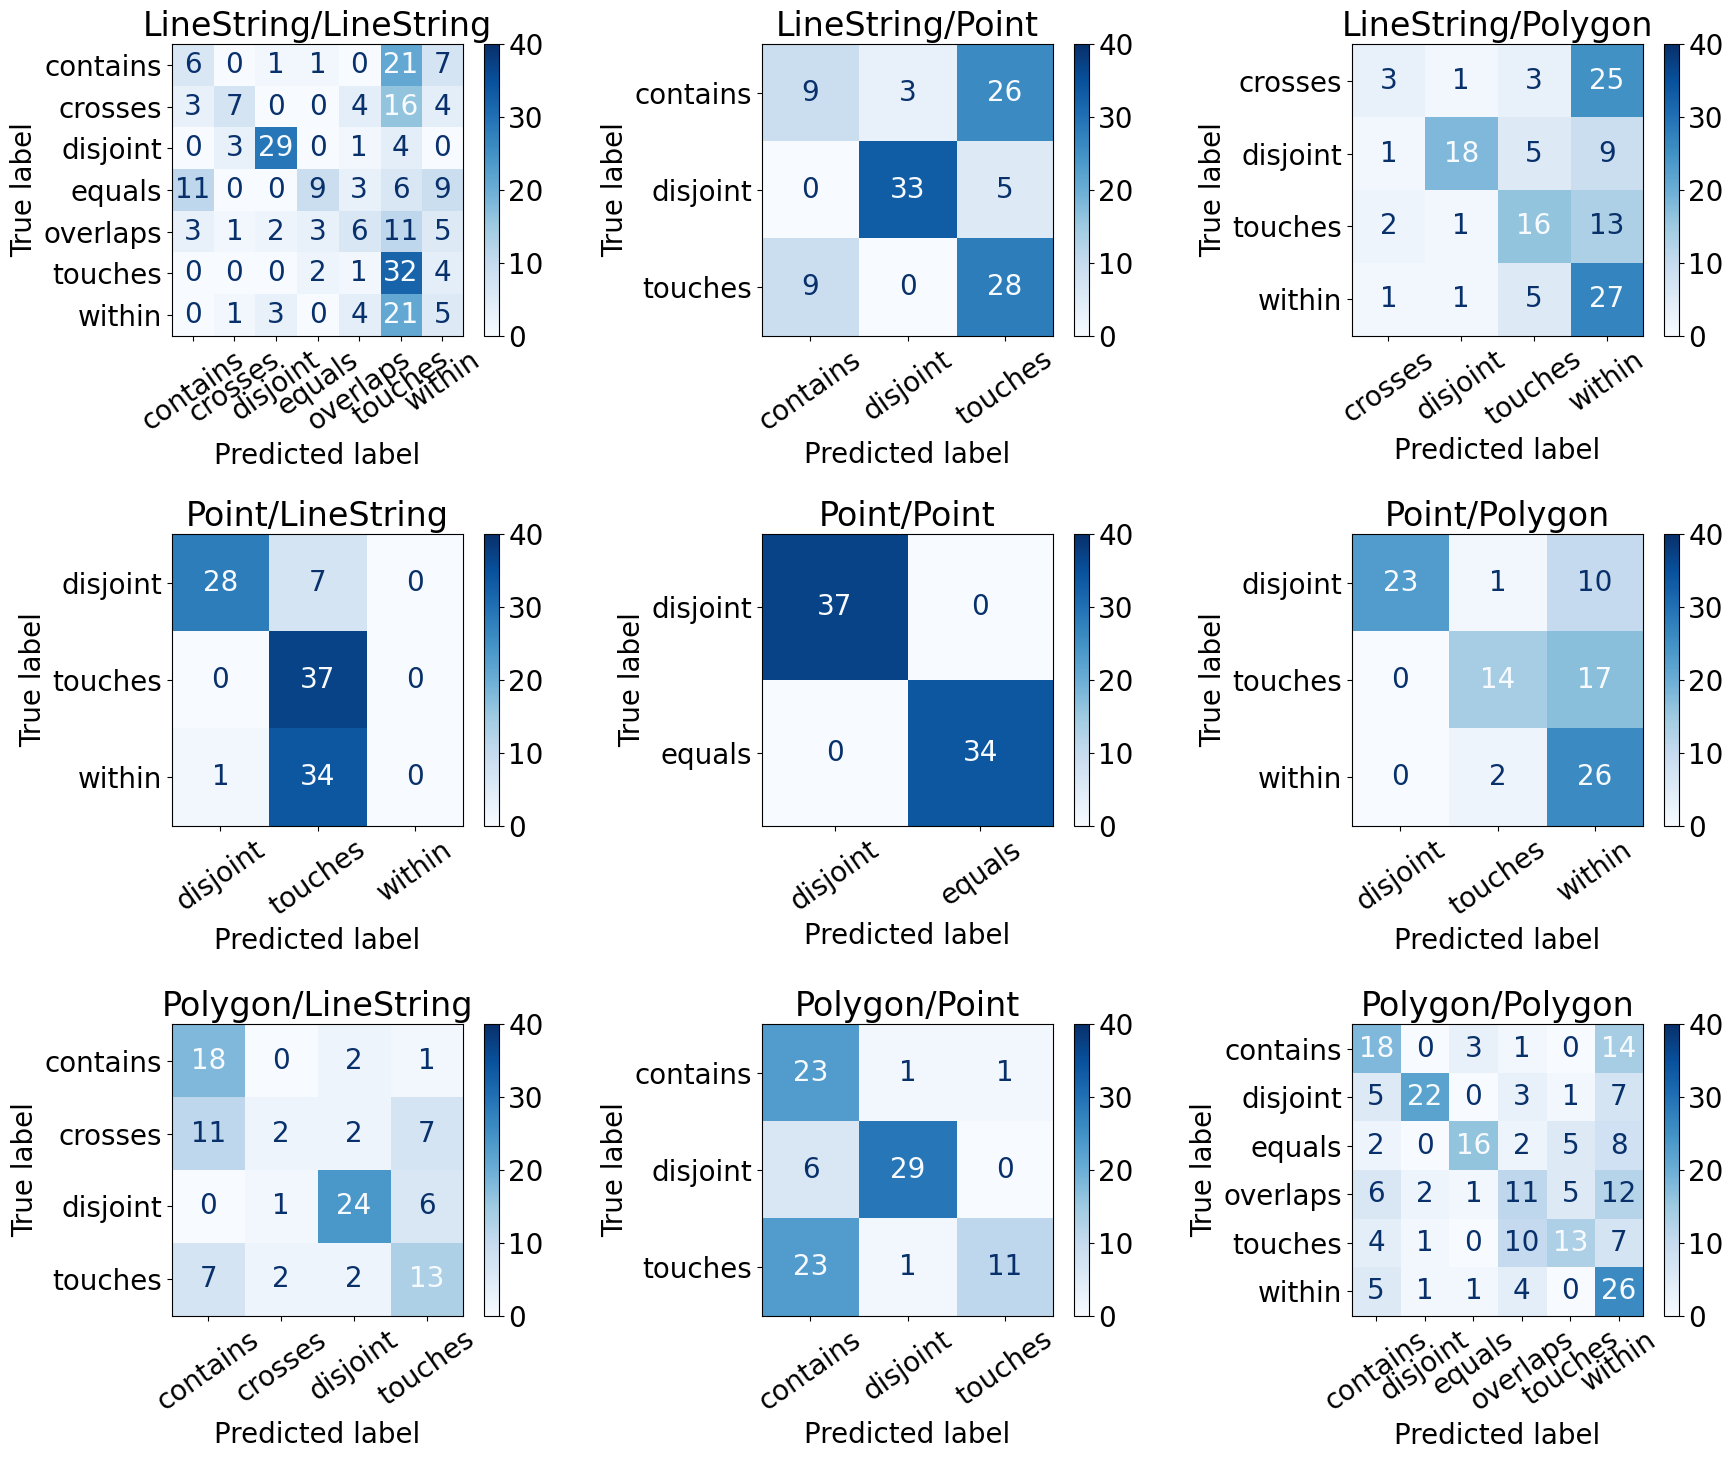

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(3, 3, figsize= (18, 15), tight_layout=True)
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'xtick.labelsize': 20})
plt.rcParams.update({'ytick.labelsize': 20})
for idx, row in comb.iterrows():
    xx = int(idx//3)
    yy = int(idx%3)

    error_cnt_comb = error_cnt[(error_cnt['geom_type_subject']==row['geom_type_subject'])&
                           (error_cnt['geom_type']==row['geom_type'])]
    cm = confusion_matrix(error_cnt_comb['predicate'], error_cnt_comb['predicate_pred'],
                          labels=sorted(list(set(error_cnt_comb['predicate']))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=sorted(list(set(error_cnt_comb['predicate']))),
                                 )
    disp.plot(cmap=plt.cm.Blues, ax=ax[xx][yy])
    disp.im_.set_clim(0, 40)
    ax[xx][yy].tick_params(axis='x', rotation=35)
    ax[xx][yy].set_title(row['geom_type_subject']+'/'+row['geom_type'])
    # plt.savefig(path+'result/final/V1/%s_%s.png'%(row['geom_type_subject'], row['geom_type']))

#     G = nx.from_pandas_edgelist(error_cnt_comb, edge_attr=True, create_using=nx.DiGraph())

#     for edge in G.edges().values():
#         edge["penwidth"] = round(1 + edge["weight"]**2 * 5, 2)
#         edge["arrowsize"] = .3

#     # for node in G.nodes().values():
#     #     node['fontsize'] = 18

#     p = nx.drawing.nx_pydot.to_pydot(G)
#     p.write_png(path+'result/final/V1/%s_%s.png'%(row['geom_type_subject'], row['geom_type']))
#     # ax[xx][yy].set_title(row['geom_type_subject']+'/'+row['geom_type'])

# #
# plt.savefig(path+'/result/final/V1/task1_cng_matrix_few_shot.png', dpi=300, bbox_inches='tight')

In [ ]:

# from sklearn.metrics import classification_report, accuracy_score

res_zero = res_all[(res_all['model']=='gpt4')&(res_all['prompt_mode']=='few_shot_cot')]

res_zero_valid = res_zero[res_zero['pred']>-1]

error_cnt = res_zero_valid[['geom_type_subject', 'geom_type', 'predicate', 'predicate_pred']]

error_cnt.head()

,geom_type_subject,geom_type,predicate,predicate_pred


In [ ]:

comb = error_cnt[['geom_type_subject', 'geom_type']].drop_duplicates().sort_values(by=['geom_type_subject', 'geom_type']).reset_index(drop=True)
comb

,geom_type_subject,geom_type


In [ ]:
comb.shape


(9, 2)

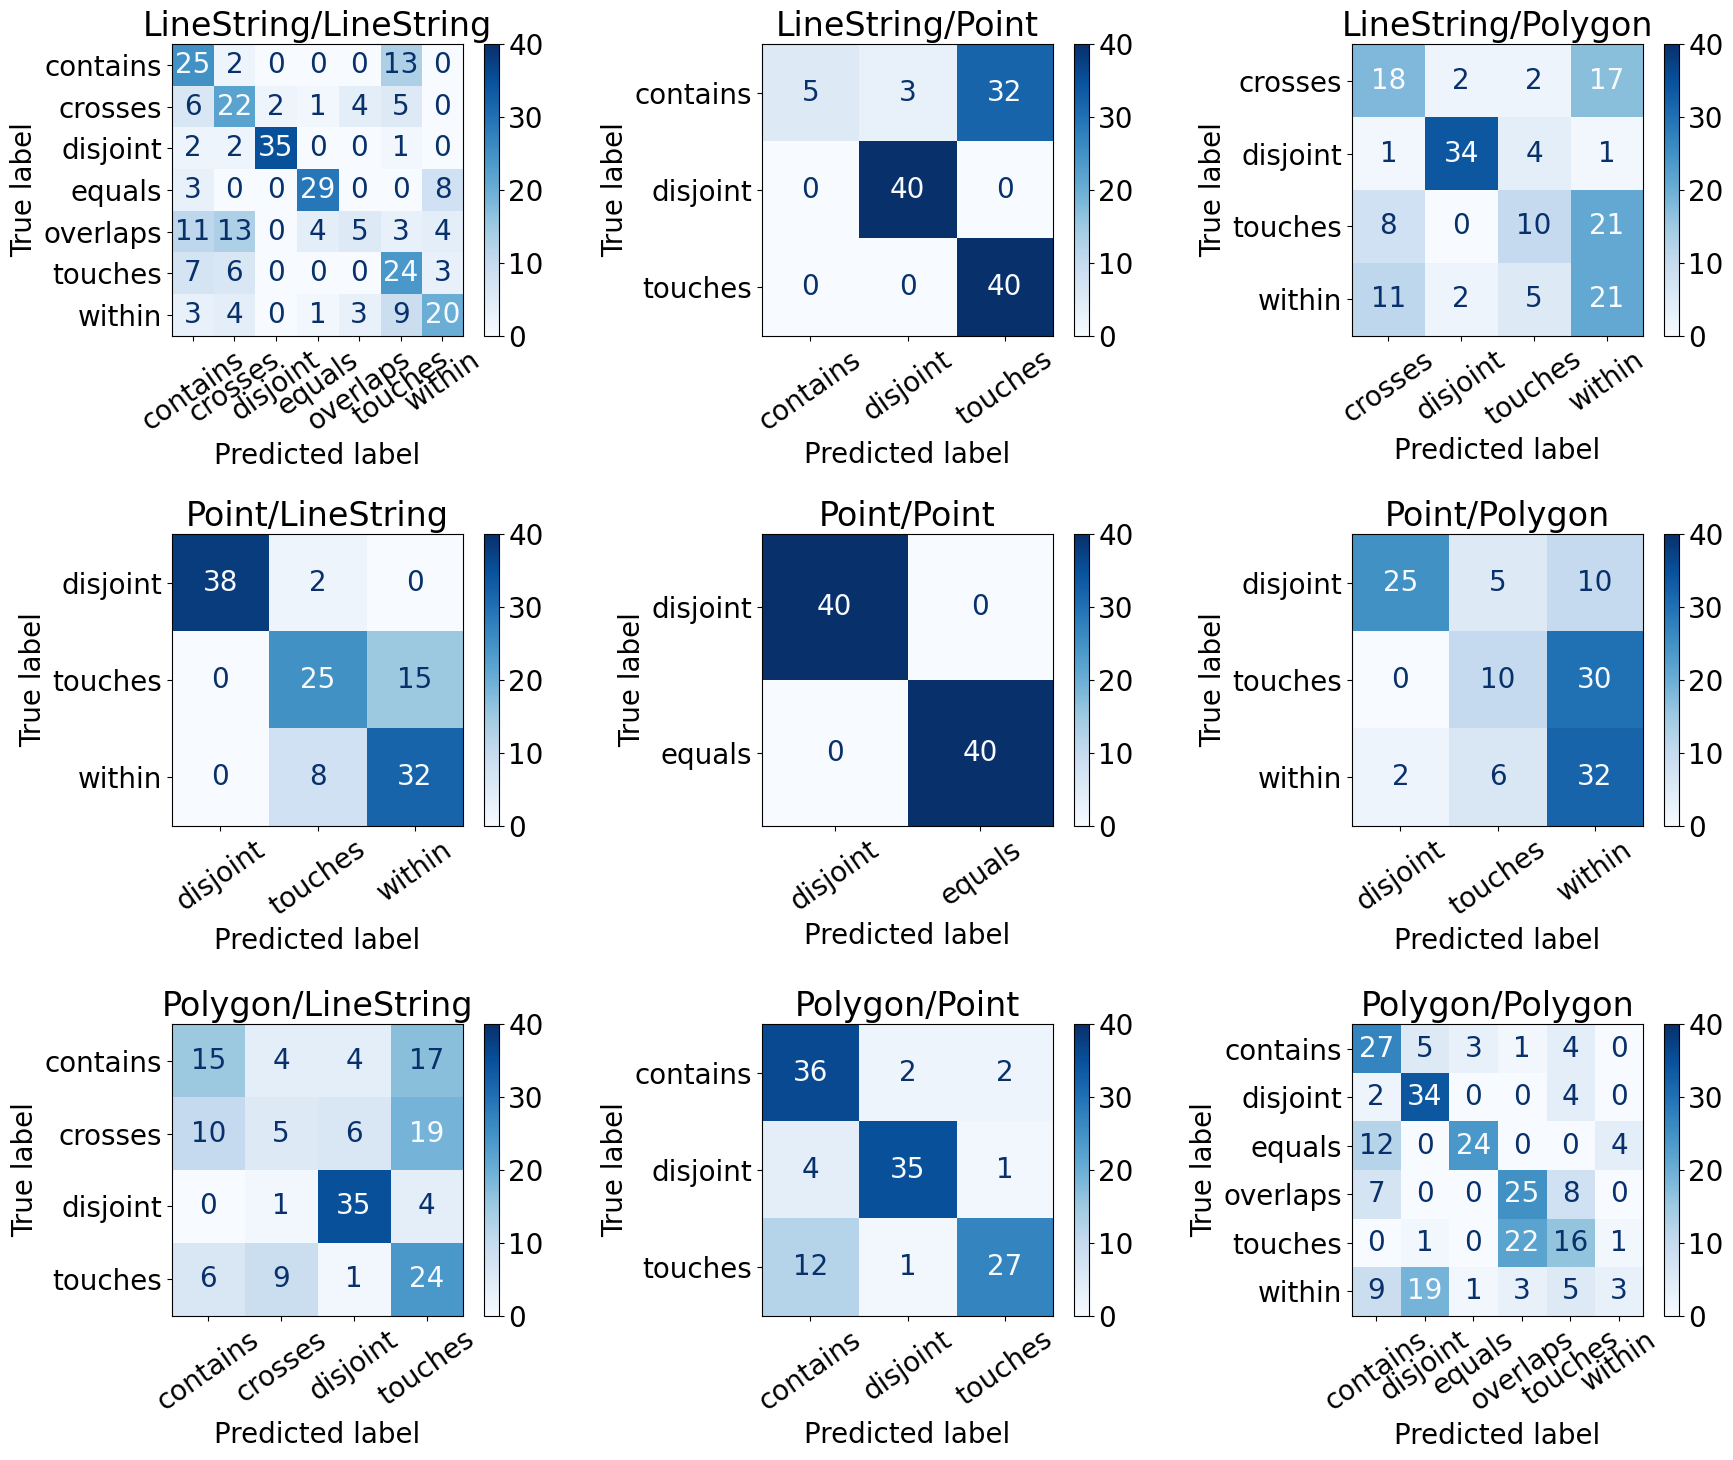

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(3, 3, figsize= (18, 15), tight_layout=True)
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'xtick.labelsize': 20})
plt.rcParams.update({'ytick.labelsize': 20})
for idx, row in comb.iterrows():
    xx = int(idx//3)
    yy = int(idx%3)

    error_cnt_comb = error_cnt[(error_cnt['geom_type_subject']==row['geom_type_subject'])&
                           (error_cnt['geom_type']==row['geom_type'])]
    cm = confusion_matrix(error_cnt_comb['predicate'], error_cnt_comb['predicate_pred'],
                          labels=sorted(list(set(error_cnt_comb['predicate']))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=sorted(list(set(error_cnt_comb['predicate']))),
                                 )
    disp.plot(cmap=plt.cm.Blues, ax=ax[xx][yy])
    disp.im_.set_clim(0, 40)
    ax[xx][yy].tick_params(axis='x', rotation=35)
    ax[xx][yy].set_title(row['geom_type_subject']+'/'+row['geom_type'])
    # plt.savefig(path+'result/final/V1/%s_%s.png'%(row['geom_type_subject'], row['geom_type']))

#     G = nx.from_pandas_edgelist(error_cnt_comb, edge_attr=True, create_using=nx.DiGraph())

#     for edge in G.edges().values():
#         edge["penwidth"] = round(1 + edge["weight"]**2 * 5, 2)
#         edge["arrowsize"] = .3

#     # for node in G.nodes().values():
#     #     node['fontsize'] = 18

#     p = nx.drawing.nx_pydot.to_pydot(G)
#     p.write_png(path+'result/final/V1/%s_%s.png'%(row['geom_type_subject'], row['geom_type']))
#     # ax[xx][yy].set_title(row['geom_type_subject']+'/'+row['geom_type'])

# #
# plt.savefig(path+'/result/final/V1/task1_cng_matrix_few_shot.png', dpi=300, bbox_inches='tight')